# Clean speech Detection

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/is-clean](https://github.com/huseinzol05/malaya-speech/tree/master/example/is-clean).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Dataset

Trained on Musan Speech, VCTK, LibriSpeech and Malaya-Speech TTS dataset to detect cleaned speeches with no background noise / music.

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


In [3]:
y, sr = malaya_speech.load('speech/vctk/p300_298_mic1.flac')
len(y) / sr

5.2068125

In [4]:
noise, _ = malaya_speech.load('speech/song/Lights-February-Air-sample.wav')

In [5]:
import IPython.display as ipd
ipd.Audio(y, rate = sr)

In [6]:
ipd.Audio(noise, rate = sr)

### List available Nemo models

In [7]:
malaya_speech.is_clean.available_nemo()

,original from,Size (MB)
huseinzol05/nemo-is-clean-speakernet,https://catalog.ngc.nvidia.com/orgs/nvidia/tea...,16.2
huseinzol05/nemo-is-clean-titanet_large,https://catalog.ngc.nvidia.com/orgs/nvidia/tea...,88.8


### Load Nemo model

```python
def nemo(
    model: str = 'huseinzol05/nemo-is-clean-speakernet',
    **kwargs,
):
    """
    Load Nvidia Nemo is clean model.
    Trained on 100, 200, 300 ms frames.

    Parameters
    ----------
    model : str, optional (default='huseinzol05/nemo-is-clean-speakernet')
        Check available models at `malaya_speech.is_clean.available_nemo()`.

    Returns
    -------
    result : malaya_speech.torch_model.nemo.Classification class
    """
```

In [8]:
model = malaya_speech.is_clean.nemo(model = 'huseinzol05/nemo-is-clean-titanet_large')

In [9]:
_ = model.eval()

### How to use Clean speech detection

We finetuned nemo models on 100 ms, 200 ms, 300 ms frames, so, split a sample into multiple chunks with length at least 100 ms should be ok.

In [10]:
frames = list(malaya_speech.utils.generator.frames(y, 100, sr, False))

In [11]:
%%time

probs = [(frame, model.predict_proba([frame])[0, 1]) for frame in frames]

CPU times: user 37.9 s, sys: 504 ms, total: 38.4 s
Wall time: 4.72 s


2023-02-21 21:07:03.019640: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 21:07:03.025132: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-21 21:07:03.025155: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: husein-MS-7D31
2023-02-21 21:07:03.025158: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: husein-MS-7D31
2023-02-21 21:07:03.025225: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-02-21 21:07:03.025239: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported vers

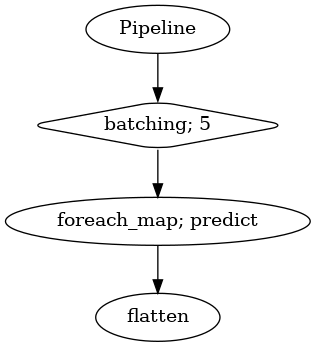

In [12]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [13]:
result = p.emit(frames)
result.keys()

/home/husein/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=480
  warnings.warn(
/home/husein/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=269
  warnings.warn(


dict_keys(['batching', 'predict', 'flatten'])

In [14]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)
grouped_vad = malaya_speech.utils.group.group_frames(grouped_vad)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

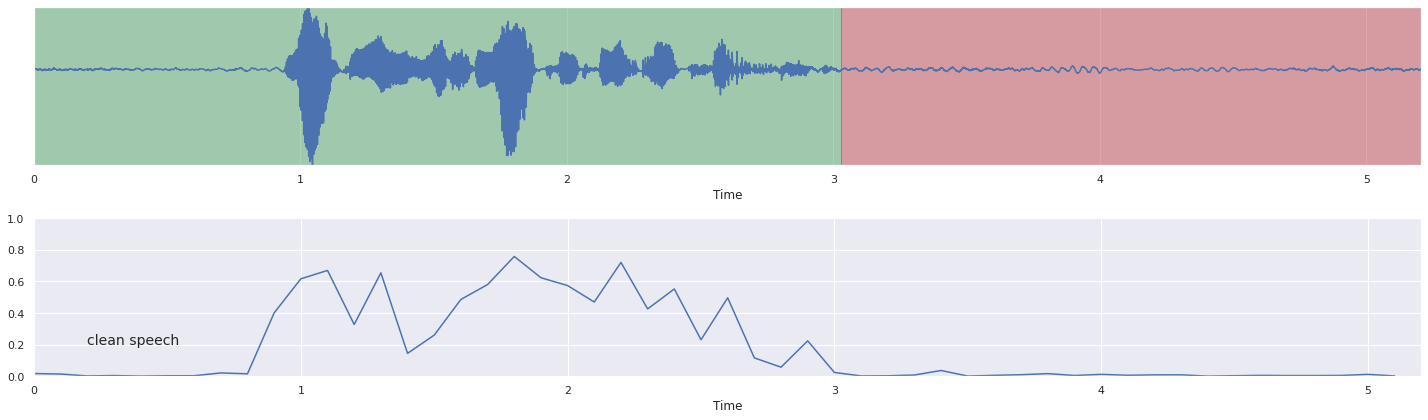

In [16]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(probs, 'clean speech', 
                                                      yaxis = True, ax = ax[1])
fig.tight_layout()
plt.show()

### how about noisy speech?

In [18]:
y = malaya_speech.augmentation.waveform.add_noise(
    y, noise, factor=0.6)

In [19]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 100, sr, False))
probs = [(frame, model.predict_proba([frame])[0, 1]) for frame in frames]

CPU times: user 20.6 s, sys: 315 ms, total: 20.9 s
Wall time: 2.43 s


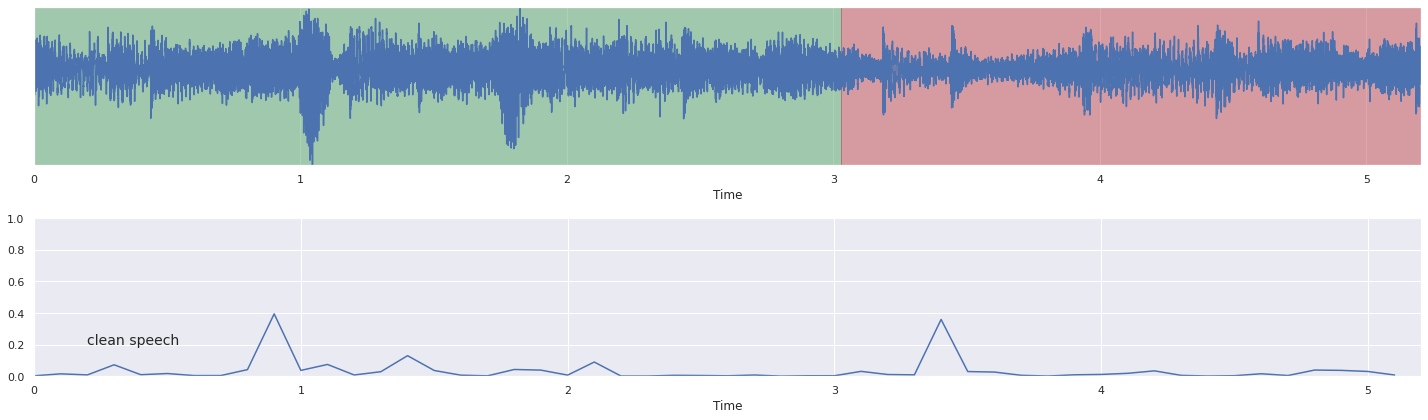

In [20]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(probs, 'clean speech', 
                                                      yaxis = True, ax = ax[1])
fig.tight_layout()
plt.show()